# Analyzing Monte Carlo Simulations

## Single Run Analysis

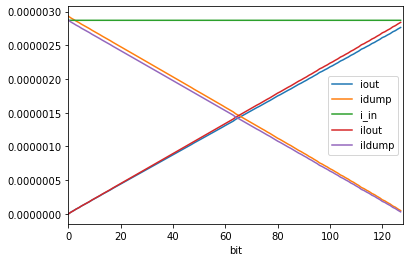

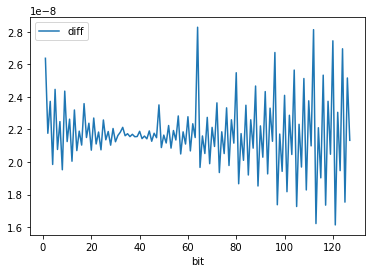

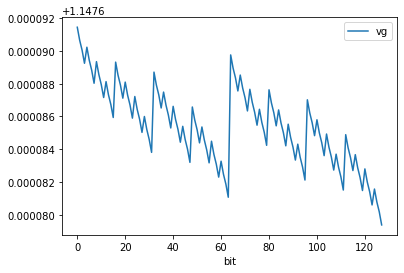

In [59]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

is_mc = True

# load data
data = pd.read_csv("data/mc_dac1.txt", sep=" +", engine='python')
# data.columns = ["net1", "iout", "idump", "i_in", "ilout", "ildump", "vg"]
data.columns = ["net1", "ilout", "ildump", "vin", "vg", "vd0", "i_in", "i_vg", "vlout", "vldump", "iout", "idump"]
# i(VloutI) i(VldumpI) v(Vin) v(Vgate) v(D0) i(VinI) i(VgateI) v(VloutV) v(VldumpV) i(Vout) i(Vdump)
data["bit"] = data.index

#generate curret steps
data["diff"] = data["iout"].diff(1)
# print sample of dataframe
# print(data.head())

data.plot("bit", ["iout", "idump", "i_in", "ilout", "ildump"], xlim=(0,128))
if is_mc:
    plt.savefig("deliverables/single_current_output_mc.png")
else:
    plt.savefig("deliverables/single_current_output.png")
plt.show()
data.plot("bit", "diff")
plt.show()

data.plot("bit", "vg")
plt.show()

## Multi-Run Analysis

/home/madvlsi/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


   net1         ilout    ildump       vin        vg       vd0      i_in  \
0   0.0 -1.693459e-12  0.000003  0.376756  1.147691  1.147691  0.000003   
0   0.0 -1.713976e-12  0.000003  0.373258  1.142488  1.142488  0.000003   
0   0.0 -1.728759e-12  0.000003  0.379331  1.142087  1.142087  0.000003   
0   0.0 -1.701310e-12  0.000003  0.372562  1.145872  1.145872  0.000003   
0   0.0 -1.702702e-12  0.000003  0.360064  1.145636  1.145636  0.000003   
0   0.0 -1.690374e-12  0.000002  0.329707  1.134518  1.134518  0.000002   
0   0.0 -1.692836e-12  0.000003  0.375158  1.146403  1.146403  0.000003   
0   0.0 -1.697404e-12  0.000003  0.355194  1.143039  1.143039  0.000003   
0   0.0 -1.683990e-12  0.000003  0.359299  1.143068  1.143068  0.000003   
0   0.0 -1.696584e-12  0.000003  0.371709  1.144939  1.144939  0.000003   

           i_vg     vlout    vldump          iout     idump  bit  diff  
0  7.304685e-12  0.237196  0.237709  1.333785e-09  0.000003    0   0.0  
0  1.556253e-11  0.240304  0

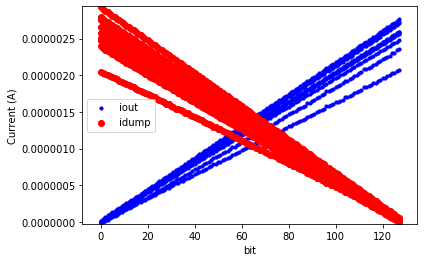

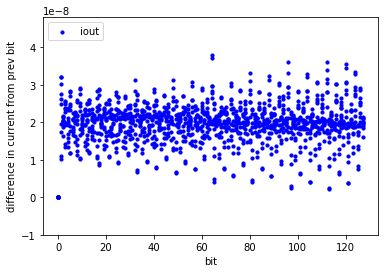

2.7705358e-08


In [60]:
runs = 10
#init data with first run
data = pd.read_csv("data/mc_dac1.txt", sep=" +", engine='python')

#combine multiple runs
for i in range(1, runs):
    data = pd.concat([data, pd.read_csv("data/mc_dac" + str(i + 1)+".txt", sep=" +", engine='python')])
# data.columns = ["net1", "iout", "idump", "i_in", "ilout", "ildump", "bryce"]
data.columns = ["net1", "ilout", "ildump", "vin", "vg", "vd0", "i_in", "i_vg", "vlout", "vldump", "iout", "idump"]
data["bit"] = data.index % 128
data["diff"] = data["iout"].diff(1)

#remove diffs at bits = 0
data["diff"].loc[data["bit"] == 0] = 0
print(data.loc[data["bit"] == 0])

fig = plt.figure()
ax1 = fig.add_subplot()

ax1.scatter(data.bit, data.iout, s=10, c='b', label='iout')
ax1.scatter(data.bit, data.idump, c='r', label='idump')
# ax1.scatter(data.bit, data.i_in, c='g', label='i in')
plt.ylim(data.iout.min()-1e-8, data.idump.max()+1e-8)
# plt.xlim(60,80)
plt.legend(loc='center left');
plt.xlabel("bit")
plt.ylabel("Current (A)")
if is_mc:
    plt.savefig("deliverables/multiple_current_output_mc.png")
else:
    plt.savefig("deliverables/multiple_current_output.png")

plt.show()

#plotting diffs
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.scatter(data["bit"], data["diff"], s=10, c='b', label='iout')
plt.ylim(data["diff"].min()-1e-8, data["diff"].max()+1e-8)
# plt.xlim(60,80)
plt.legend(loc='upper left');
plt.xlabel("bit")
plt.ylabel("difference in current from prev bit")
plt.show()

#density plot of diff
# data["diff"].plot.density()

print(data["iout"].iloc[1])

### DNL and INL distributions

2.7705358e-08


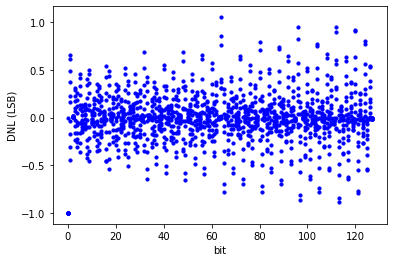

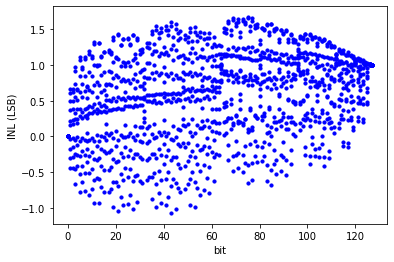

max DNL (absolute value):  1.0524987757759292
max INL (absolute value):  1.6782513695519383


In [61]:
#generate DNL & INL Columns
dnl = []
inl = []
print(data["iout"].iloc[1])
for i in range(128*runs):    
    if i % 128 == 0:
        lsb_current = (data["iout"].iloc[i+127] - data["iout"].iloc[i])/128
        dnl.append(data["diff"].iloc[i] / lsb_current - 1)
        inl.append(0)
    else:
        dnl.append(data["diff"].iloc[i] / lsb_current - 1)
        inl.append(dnl[-1] + inl[-1])
        

dnl[0] = 0
data["dnl"] = dnl
data["inl"] = inl

# print(dnl)
#DNL
fig = plt.figure()
ax1 = fig.add_subplot()

ax1.scatter(data.bit, data.dnl, s=10, c='b', label="dnl")
plt.xlabel("bit")
plt.ylabel("DNL (LSB)")
if is_mc:
    plt.savefig("deliverables/dnl_mc.png")
else:
    plt.savefig("deliverables/dnl.png")
plt.show()

#INL
fig = plt.figure()
ax1 = fig.add_subplot()

ax1.scatter(data.bit, data.inl, s=10, c='b', label="inl")
plt.xlabel("bit")
plt.ylabel("INL (LSB)")
if is_mc:
    plt.savefig("deliverables/inl_mc.png")
else:
    plt.savefig("deliverables/inl.png")
plt.show()


print("max DNL (absolute value): ", max(abs(data.dnl)))
print("max INL (absolute value): ", max(abs(data.inl)))

1642 202
2.52811491e-06
2.505588e-06
percent error:  0.6187886253952017 %


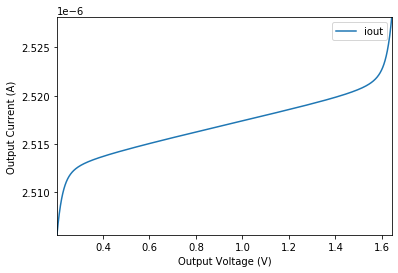

In [35]:
# Vout Sweep

is_mc = False

data = pd.read_csv("data/vout_sweep.txt", sep=" +", engine='python')
# data.columns = ["vsweep", "i_in", "iout", "idump", "ilout", "ildump", "vbp", "vcn"]
# data.columns = ["vsweep", "i_in", "iout", "ibias", "iv1", "iv2", "vbp", "vcn"]
data.columns = ["vsweep", "ilout", "ildump", "vin", "vg", "vd0", "i_in", "i_vg", "vlout", "vldump", "iout", "idump"]
# print(data.head())
# print(data.ibias.iloc[0])

mid = 922
ulim = int(.4*1800 + mid)
llim = int(mid - .4*1800)
print(ulim, llim)

data.plot("vsweep", "iout", xlim=(data.vsweep.iloc[llim], data.vsweep.iloc[ulim]), ylim=(data.iout.iloc[llim], data.iout.iloc[ulim]))
plt.ylabel("Output Current (A)")
plt.xlabel("Output Voltage (V)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
if is_mc:
    plt.savefig("deliverables/vout_sweep_mc.png")
else:
    plt.savefig("deliverables/vout_sweep.png")
    
print(data.iout.iloc[ulim])
print(data.iout.iloc[llim])

error = ((data.iout.iloc[ulim] - data.iout.iloc[llim]) / data.iout.iloc[ulim]) / (data.vsweep.iloc[ulim]-data.vsweep.iloc[llim])
print("percent error: ", error*100, "%")

1300 749
2.51504407e-06
2.50811388e-06
0.002755494459387313
percent error:  0.5000897385457919 %
lower voltage:  1.249
upper voltage:  1.8


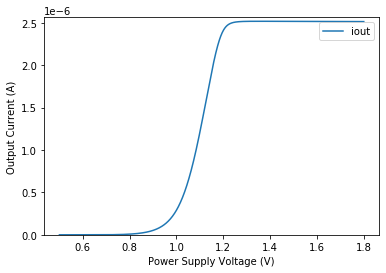

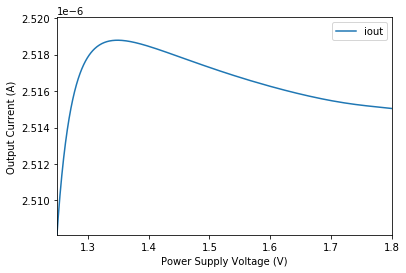

In [111]:
# Vdd Sweep

is_mc = False

data = pd.read_csv("data/vdd_sweep.txt", sep=" +", engine='python')
# data.columns = ["vsweep", "i_in", "iout", "idump", "ilout", "ildump", "vbp", "vcn"]
# data.columns = ["vsweep", "i_in", "iout", "ibias", "iv1", "iv2", "vbp", "vcn"]
data.columns = ["vsweep", "ilout", "ildump", "vin", "vg", "vd0", "i_in", "i_vg", "vlout", "vldump", "iout", "idump"]
# print(data.head())
# print(data.ibias.iloc[0])
# print(data.shape)
mid = 924
ulim = 1300
llim = 749
print(ulim, llim)

data.plot("vsweep", "iout", ylim=(0, data.iout.iloc[ulim] + .05e-6))
plt.ylabel("Output Current (A)")
plt.xlabel("Power Supply Voltage (V)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
if is_mc:
    plt.savefig("deliverables/vds_sweep_full_mc.png")
else:
    plt.savefig("deliverables/vds_sweep_full.png")

data.plot("vsweep", "iout", xlim=(data.vsweep.iloc[llim], data.vsweep.iloc[ulim]), ylim=(data.iout.iloc[llim], data.iout.iloc[ulim] + .005e-6))
plt.ylabel("Output Current (A)")
plt.xlabel("Power Supply Voltage (V)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
if is_mc:
    plt.savefig("deliverables/vds_sweep_mc.png")
else:
    plt.savefig("deliverables/vds_sweep.png")
    
print(data.iout.iloc[ulim])
print(data.iout.iloc[llim])
print((data.iout.iloc[ulim] - data.iout.iloc[llim]) / data.iout.iloc[ulim])

error = ((data.iout.iloc[ulim] - data.iout.iloc[llim]) / data.iout.iloc[ulim]) / (data.vsweep.iloc[ulim]-data.vsweep.iloc[llim])
print("percent error: ", error*100, "%")
print("lower voltage: ", data.vsweep.iloc[llim])
print("upper voltage: ", data.vsweep.iloc[ulim])